In [1]:
import astropy.units as u
import astropy.table as tabl
import astropy.constants as c
import astropy.io.votable as votab
import astropy.io.ascii 
import astropy.units as u
from lgs_utilties import zero_mag_Vband
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib as mpl
import os
import poppy
import numpy as np
from lgs_utilties import parse_table

%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('pdf',fonttype = 42)
home=os.path.expanduser("~/")


#plt.rcParams["font.size"]=9
import lgs_utilties as lgs

/Users/edouglas/anaconda/envs/astroconda/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/edouglas/anaconda/envs/astroconda/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/edouglas/anaconda/envs/astroconda/lib/python3.6/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for ftp://ftp.stsci.edu/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/edouglas/anaconda/envs/astroconda/lib/python3.6/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for ftp://ftp.stsci.edu/cdbs/mtab/*_tmt.fits
  'n

In [2]:
#Rx Params:
D_t=9.20*u.m
wavelength=980*u.nm
sci_wavel=600*u.nm
efficiency=0.37#QE, transmission, gaussian wings within telescope aperture

r=1.15*u.m/2.0 #Eisenhower,  etal 2015. doi:10.1117/12.2188008. table 1

tx_rx_separation=2*(D_t/2)**2/wavelength
tx_rx_separation.to(u.km)

<Quantity 43183.67346939 km>

In [3]:
seg_pixels= 2*np.sqrt(3)*(30)**2
seg_area= 2*np.sqrt(3)*r**2 #regular hexagon, r is inscribed circle, wikipedia...


#Tx params
U=u.mm*100

output_waist=0.5*U/3. #radius of a U with an oversized optic to prevent diffraction on the edges

from astropy.table import Table

#try to get from fiber to collimator
fiber_NA = 0.12 #SM600
fiber_MFD = 4.5*u.um #SM600 or 980HP
jitter_cubesat = 1.5*u.arcsec #half angle (3 sigma?)
fl_collimator = 250*u.mm
diam_beam=fiber_NA*fl_collimator

wf_exit_aper=poppy.FresnelWavefront(beam_radius=output_waist,
                         oversample=32,npix=128,
                         wavelength=wavelength)

diam_beam

<Quantity 30. mm>

## Nominal Range

In [4]:
print(tx_rx_separation.decompose().to(u.km))
tx_rx_separation = np.round(tx_rx_separation.decompose().to(u.km))
print(tx_rx_separation.decompose().to(u.km))

43183.67346938775 km
43184.0 km


## Divergence

In [5]:
fl_2_5U=(2.5*100*u.mm)
divergence_2_5U=fiber_MFD/fl_2_5U*u.radian
fl_25U=(25*100*u.mm)
divergence_25U=fiber_MFD/fl_25U*u.radian
print("full angle MFD divergence: "+str(divergence_2_5U.to(u.arcsec)))
gaussian_diverge=(wf_exit_aper.divergence*u.rad).to(u.arcsec)
print("full angle guassian waist divergence: "+str((gaussian_diverge)))
print(" Focal length to match MFD to waist: "+str(fiber_MFD.to(u.mm)/gaussian_diverge.to(u.radian).value))


#find minimum half-angle divergence
min_divergence=np.max([divergence_2_5U.to(u.arcsec).value,(wf_exit_aper.divergence*u.rad).to(u.arcsec).value])/2.0*u.arcsec
print("minimum half angle divergence:"+str(min_divergence))

full angle MFD divergence: 3.7127665124477343 arcsec
full angle guassian waist divergence: 7.721160535227622 arcsec
 Focal length to match MFD to waist: 120.21400460165026 mm
minimum half angle divergence:3.860580267613811 arcsec


## wfe/segment (ZWFS)

via `laser_error_budget/WFE_budget.ipynb`

$\sqrt((0.5/photons))*\lambda/(2\pi)$

In [6]:
def wfe_per_photon(photons,wavel):
    #for ZWFS, from WFE_budget.ipynb, N'Daiye eq. (?)
    return np.sqrt((0.5*u.photon/photons))*wavel/(2*np.pi)
def contrast_per_wfe(wfe,wavel):
    '''
    traub and oppenheimer eq. 123
    rescaled to RMS wfe asssuming zero mean sine wave disturbance
    
    '''
    
    return (np.pi*wfe/wavel/(2*np.sqrt(2)))**2
def t_exp_per_vmag(mag,sci_wavel,wavel,contrast=1e-10,efficiency=0.05):
    t_exp=(sci_wavel**2/(16*wavel**2*contrast)/(efficiency*zero_mag_Vband/u.photon*10**(-mag/2.5)*seg_area))
    return t_exp
#,wfe_per_photon(seg_area*zero_mag_Vband*10**(mag/2.5),sci_wavel)/wavel/np.sqrt(2))**2/contrast


#validate Jared's model, assuming RMS there is both positive and negative?
contrast_per_wfe(5*u.pm,500*u.nm).decompose()

<Quantity 1.23370055e-10>

magnitudes:[-5  0  5 10]
exposure times:[4.49565171e-02 4.49565171e+00 4.49565171e+02 4.49565171e+04] s


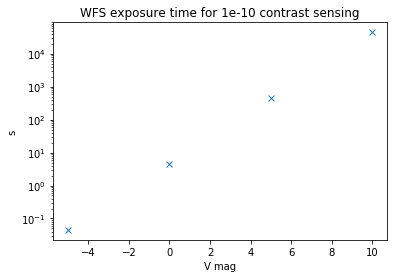

In [7]:
key_mags=np.array([-5,0,5,10])

key_times=t_exp_per_vmag(mag=key_mags,contrast=1e-11,sci_wavel=sci_wavel,wavel=wavelength).decompose()
plt.plot(key_mags,key_times,'x')
plt.yscale("log")
plt.xlabel("V mag")
plt.ylabel(key_times.unit)
print("magnitudes:"+str(key_mags))
print('exposure times:'+str(key_times))
plt.title("WFS exposure time for 1e-10 contrast sensing")
plt.savefig("figs/wfs_exp_vs_Vmag.png",bbox_inches="tight")

In [8]:
link=lgs.link(tx_divergence=10*u.arcsec,
                tx_laser_power=100*u.watt,
              tx_wavel=wavelength,
              tx_rx_separation=tx_rx_separation,)
def contrast(link,
             sample_freq=1000*u.hertz):
    incident = np.median(link.rx_phot_sec)*efficiency
    print("Tx power: "+str(link.tx_laser_power))
    print(sample_freq)
    
    seg_incident = incident*seg_area/link.rx_Area
    wfe_segment=(wfe_per_photon(seg_incident/sample_freq,wavelength)).to(u.pm)
    #just using same sampling as Jared, is this realistic?
    phot_per_pix = seg_incident/seg_pixels
    wfe_sigma_pix=np.sqrt((0.5*u.photon/phot_per_pix*sample_freq))*link.tx_wavel/(2*np.pi)
    print("WFE per pixel: "+str(np.round(wfe_sigma_pix.to(u.picometer))))
    wfe_segment=np.sqrt(wfe_sigma_pix**2/seg_pixels)
    print("mean error per segment: "+str(np.round(wfe_segment.to(u.picometer),3)))

    return contrast_per_wfe(wfe_segment,sci_wavel)

contrast(link).decompose()


initing
Tx power: 100.0 W
1000.0 Hz
WFE per pixel: 78.0 pm
mean error per segment: 1.392 pm


<Quantity 6.63997137e-12>

In [9]:
import importlib 
importlib.reload(lgs)
link=lgs.link(tx_divergence=10*u.arcsec,
                tx_laser_power=100*u.watt,
              tx_wavel=wavelength,
              tx_rx_separation=tx_rx_separation,)
link.force_band='z\''

link.magnitude

initing
z'


<Quantity -8.23716089>

In [10]:
exoarch_mission = "http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=missionstars&format=votable&select=*"
exoarch_exocat = "http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=mission_exocat&format=votable&select=*"


#if you need to update votable:
#mission_stars_file=astropy.utils.data.download_file(exoarch_mission, 
#                                                        cache=False,
#                                                        show_progress=True,
#                                                        timeout=10) #regular call was timing out
#exocat_stars_file=astropy.utils.data.download_file(exoarch_exocat, 
#                                                        cache=False,
#                                                        show_progress=True,
#                                                        timeout=10) #regular call was timing out

#exocat_stars = votab.parse(exocat_stars_file,
#datatype_mapping={"char": "unicodeChar"}).get_first_table().to_table()
#mission_stars = votab.parse(mission_stars_file,
#datatype_mapping={"char": "unicodeChar"}).get_first_table().to_table()#exocat_stars.write("exocat_stars.votable",format="votable")
#mission_stars.write("data/mission_stars.votable",format="votable")
#exocat_stars.write("data/exocat_stars.votable",format="votable")


mission_stars = votab.parse("data/mission_stars.votable",
                            datatype_mapping={"char": "unicodeChar"}).get_first_table().to_table()

exocat_stars = votab.parse("data/exocat_stars.votable",
                           datatype_mapping={"char": "unicodeChar"}).get_first_table().to_table()

exocat_stars



hip_name,hd_name,gj_name,tm_name,st_exocatflag,st_coronagflag,st_starshadeflag,st_wfirstflag,st_rvflag,st_lbtiflag,st_probeflag,st_k2flag,st_k2campaign,st_ppnum,wds_designation,wds_sep,wds_deltamag,ra,raerr,rastr,dec,decerr,decstr,st_glon,st_glonerr,st_glat,st_glaterr,st_fracplxunc,st_dist,st_disterr1,st_disterr2,st_pmra,st_pmraerr,st_pmdec,st_pmdecerr,st_vmag,st_vmagerr,st_vmagsrc,st_kmagsrc,st_bmv,st_bmverr,st_bmvsrc,st_vmk,st_vmkerr,st_vmksrc,st_spttype,st_lumclass,st_spttag,st_mbol,st_mbolerr,st_mbolsrc,st_mbolflag,st_lbol,st_lbolerr,st_lbolsrc,st_teff,st_tefferr,st_teffsrc,st_logg,st_loggerr,st_loggsrc,st_metfe,st_metfeerr,st_metfesrc,st_metratio,st_rad,st_raderr,st_radsrc,st_mass,st_masserr,st_masssrc,st_age,st_ageerr,st_agesrc,st_actclass,st_eeidau,st_eeidauerr,st_eeidmas,st_eeidmaserr,st_fpbearth,st_fpbeartherr,st_vmagearth,st_vmageartherr,st_nts,st_nplc,st_nglc,st_nrvc,st_naxa,st_nimg,st_nspec,st_j2m,st_j2merr,st_j2mlim,st_h2m,st_h2merr,st_h2mlim,st_ks2m,st_ks2merr,st_ks2mlim,st_wise1,st_wise1err,st_wise1lim,st_wise2,st_wise2err,st_wise2lim,st_wise3,st_wise3err,st_wise3lim,st_wise4,st_wise4err,st_wise4lim,star_name,id
,,,,,,,,,,,,,,,arcs,mags,deg,degrees,,deg,degrees,,degrees,degrees,degrees,degrees,,pc,pc,pc,mas / yr,mas / yr,mas / yr,mas / yr,mags,mags,,,mags,mags,,mags,mags,,,,,mags,mags,,,Lsun,Lsun,,K,K,,cm/s**2,cm/s**2,,dex,dex,,,Rsun,Rsun,,Msun,Msun,,Gyr,Gyr,,,AU,AU,mas,mas,,,mag,mag,,,,,,,,mags,mags,,mags,mags,,mags,mags,,mags,mags,,mags,mags,,mags,mags,,mags,mags,,,
object,object,object,object,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,object,float64,float64,float64,float64,object,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,object,float64,float64,object,object,object,object,float64,float64,object,int32,float64,float64,object,float64,float64,object,float64,float64,object,float64,float64,object,object,float64,float64,object,float64,float64,object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,object,object
HIP 3185,HD 3795,GJ 27.2,2MASS J00403279-2348172,1,0,0,0,0,0,0,0,--,0,,--,--,10.135,--,00h40m32.40s,-23.804,--,-23d48m14.4s,85.837351,--,-85.86506,--,0.01,28.89,0.29,-0.29,635.5,--,-363.3,--,6.14,0.01,G,,0.72,0.01,G,--,--,,G3/5V,MAINSEQ,G,3.84,0.04,,0,2.76,0.11,B-V,5369.0,--,2005ApJS..159..141V,4.06,--,2007ApJS..168..297T,-0.58,--,,[Fe/H],1.9,--,2007ApJS..168..297T,1.46,--,2007ApJS..168..297T,11.6,--,2007ApJS..168..297T,VI,1.66,--,57.55,--,0.0,--,32.09,--,1,0,1,0,0,1,2,5.13,0.288,0,4.545,0.214,0,4.333,0.02,0,--,--,--,--,--,--,--,--,--,--,--,--,HIP 3185,0
HIP 3203 A,HD 3821,GJ 9020 A,2MASS J00404747-0713574,1,0,0,0,0,0,0,0,--,0,00408-0714,--,--,10.198,--,00h40m47.48s,-7.232,--,-07d13m56.6s,115.211641,--,-69.944399,--,0.02,26.5,0.54,-0.52,0.6,--,-91.6,--,7.02,0.01,G,2MASS,0.62,0.02,G,1.5,0.03,,G2/3V,MAINSEQ,G,4.9,0.05,,1,0.98,0.06,V-K,5828.0,--,2005ApJS..159..141V,4.51,--,2007ApJS..168..297T,-0.06,--,,[Fe/H],0.95,--,2007ApJS..168..297T,1.01,--,2007ApJS..168..297T,5.0,--,2005ApJS..159..141V,A,0.99,--,37.3,--,0.0,--,31.84,--,1,0,1,0,0,1,0,5.911,0.019,0,5.604,0.038,0,5.522,0.026,0,--,--,--,--,--,--,--,--,--,--,--,--,HIP 3203 A,1
HIP 3206,HD 3765,GJ 28,2MASS J00404929+4011133,1,0,0,0,0,0,0,0,--,0,,--,--,10.204,--,00h40m49.00s,40.189,--,+40d11m19.7s,120.734384,--,-22.637565,--,0.01,17.33,0.18,-0.17,355.7,--,-668.9,--,7.36,0.01,G,2MASS,0.94,0.02,G,2.2,0.02,,K2V,MAINSEQ,K,6.17,0.04,,0,0.37,0.05,V-K,5032.0,--,2005ApJS..159..141V,4.58,--,2007ApJS..168..297T,0.18,--,,[Fe/H],0.79,--,2007ApJS..168..297T,0.85,--,2007ApJS..168..297T,2.0,--,2007ApJS..168..297T,VI,0.61,--,35.18,--,0.0,--,31.13,--,1,0,1,0,0,2,6,5.694,0.024,0,5.272,0.051,0,5.164,0.0

In [11]:

import pandas as pd
#http://www.recons.org/TOP100.posted.htm (converted to CSV with LibreOffice)
recons2012=pd.read_csv('data/recons2012.csv',header=0,
                       comment="#",
                       skiprows=[1,2,3,4,5],
                       skipfooter=100,na_values=["_________"])#, delimiter="  ")

/Users/edouglas/anaconda/envs/astroconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


In [12]:
mags=np.arange(0,50)


In [13]:

def quant_hist(param,**kwargs):
    plt.hist(param,normed=True,bins="auto",linewidth=.1,**kwargs)
    plt.xlabel(param.unit)
    plt.ylabel("Probability Density")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


### find power necessary to sense at 1 minute cadence

In [14]:
import copy
sample_freq=1/u.min
sample_ratio =((1000 *u.hertz/sample_freq).decompose().value)
link_slow=copy.copy(link)
link_slow.tx_laser_power=link.tx_laser_power/(sample_ratio)
print("Tx power: "+str(link_slow.tx_laser_power))
incident = np.median(link_slow.rx_phot_sec)*efficiency
seg_incident = incident*seg_area/link_slow.rx_Area
phot_per_pix = seg_incident/seg_pixels
wfe_sigma_pix=np.sqrt((0.5*u.photon/phot_per_pix*sample_freq))*link_slow.tx_wavel/(2*np.pi)
print("WFE per pixel: "+str(np.round(wfe_sigma_pix.to(u.picometer))))
print("mean error per segment: "+str(np.round(np.sqrt(wfe_sigma_pix**2/seg_pixels).to(u.picometer),3)))

Tx power: 0.0016666666666666668 W
WFE per pixel: 78.0 pm
mean error per segment: 1.392 pm


## Link Budget Scenerios

The 
$dS/I=\frac{I_1-I_2}{I_0}= e^{\frac{-2x^2}{w^2}}-e^{\frac{-2(x+x_0)^2}{w^2}}$
Where $x_0$ is pointing error, and $\sigma$ is the beamwidth, and $I_0$ is the gaussian intensity. 

if x=0, then $1-e^{\frac{-2(x_0)^2}{\sigma^2}}$ which taylor expands to $dS=1-(1-\frac{2(x_0)^2}{\sigma^2})=\frac{2x_0^2}{\sigma^2}=d\phi$
if our requirement is 10 pm.

## CubeSat Pointing

In [15]:
import importlib 
importlib.reload(lgs)

dphi=2*(10*u.pm*2*np.pi)/link.tx_wavel
x_0_cubesat=(10*u.arcsecond).to(u.radian)
w_cubesat=(np.sqrt(2*x_0_cubesat**2/(dphi))).decompose()
print(w_cubesat.to(u.arcmin))
pt=tabl.QTable()
pt["name"]=["mean","stdev"]
pt["tx_laser_power"]=[50,0]*u.watt
pt["tx_wavel"]=[link.tx_wavel.to(u.nm).value,0]*u.nm
wl = pt["tx_wavel"][0]
#pt["rx_radius"]=[D_t.value/2,0]*u.nm

pt["tx_rx_separation"]=(np.array([tx_rx_separation.value,0])*tx_rx_separation.unit).to(u.km)
#pt["tx_jitter"]=[10,5]*u.arcsec
pt["rx_throughput"]=[efficiency,0] #because of monitoring channel
pt["tx_divergence"]=[np.round(w_cubesat.to(u.arcsec).value),0]*u.arcsec




#print(parse_table(pt,n=1))
table_link=lgs.link(**parse_table(pt,n=1))
table_link.force_band="z\'"

table_link.magnitude

20.814781355115667 arcmin
initing
z'


<Quantity 2.99822484>

In [16]:

try:
    print(""+str(table_link.magnitude.round(3))+" mag")
except Exception as err:
    print(err)
    

pt["tx jitter"] = x_0_cubesat.to(u.arcsecond)
table_link.force_band="z\'"


pt.write("cubesat_pointing_table.tex",format="latex",overwrite=True)
pt.show_in_notebook()

z'
2.998 mag


idx,name,tx_laser_power,tx_wavel,tx_rx_separation,rx_throughput,tx_divergence,tx jitter
,,W,nm,km,,arcsec,arcsec
0,mean,50.0,980.0,43184.0,0.37,1249.0,10.0
1,stdev,0.0,0.0,0.0,0.0,0.0,10.0


## precision pointing

In [17]:

x_0=(15*u.milliarcsecond).to(u.radian)
sigma=(np.sqrt(2*x_0**2/(dphi))).decompose()
print(sigma.to(u.arcsec))


if sigma <min_divergence:
    sigma=min_divergence
print(sigma.to(u.arcsec))

1.87333032196041 arcsec
3.860580267613811 arcsec


In [18]:
tx_rx_separation = np.round(tx_rx_separation.decompose().to(u.km))


pt=tabl.QTable()
pt["name"]=["mean","stdev"]
pt["tx_laser_power"]=[5,0]*u.watt
pt["tx_wavel"]=[link.tx_wavel.to(u.nm).value,0]*u.nm
wl = pt["tx_wavel"][0]
#pt["rx_radius"]=[16.8/2,0]*u.nm

pt["tx_rx_separation"]=(np.array([tx_rx_separation.to(u.km).value,0])*tx_rx_separation.unit).to(u.km)
#pt["tx_jitter"]=[10,5]*u.arcsec
pt["rx_throughput"]=[efficiency,0] 
pt["tx_divergence"]=np.round([sigma.to(u.arcsec).value,0]*u.arcsec,3)



#print(parse_table(pt,n=1))
table_link=lgs.link(**parse_table(pt,n=1))

try:
    print("V="+str(table_link.magnitude.round(3))+" mag")
except Exception as err:
    print(err)
pt["tx jitter"] = x_0.to(u.arcsecond)
#pt["t_exp"] = .01*u.second
#pt["$\lambda/D$ Contrast"] = np.round(contrast(table_link,sample_freq=1/(pt["t_exp"])),11)
table_link.force_band="z\'"
pt[r"$m$"] = np.round(table_link.magnitude,1)
pt[r"band"] =r"$\textrm{"+str(table_link.band)+"}$"



pt.write("precise_pointing_table.tex",format="latex",overwrite=True)
print(contrast(table_link))
pt.show_in_notebook()

pt_1st =pt[0]



initing
wavelength (980.0 nm) has no specified filter
unknown band
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
'NoneType' object has no attribute 'round'
z'
Tx power: 5.0 W
1000.0 Hz
WFE per pixel: 221.0 pm
mean error per segment: 3.951 pm
5.3505382966538704e-11


In [19]:

pt=tabl.QTable()
pt["name"]=["mean","stdev"]
pt["tx_laser_power"]=[0.005,0]*u.watt
pt["tx_wavel"]=[link.tx_wavel.to(u.nm).value,0]*u.nm
wl = pt["tx_wavel"][0]
#pt["rx_radius"]=[16.8/2,0]*u.nm

pt["tx_rx_separation"]=(np.array([tx_rx_separation.to(u.km).value,0])*tx_rx_separation.unit).to(u.km)
#pt["tx_jitter"]=[10,5]*u.arcsec
pt["rx_throughput"]=[efficiency,0] 
pt["tx_divergence"]=np.round([sigma.to(u.arcsec).value,0]*u.arcsec,3)



#print(parse_table(pt,n=1))
table_link=lgs.link(**parse_table(pt,n=1))

try:
    print("V="+str(table_link.magnitude.round(3))+" mag")
except Exception as err:
    print(err)
pt["tx jitter"] = x_0.to(u.arcsecond)
#pt["t_exp"] = .01*u.second
#pt["$\lambda/D$ Contrast"] = np.round(contrast(table_link,sample_freq=1/(pt["t_exp"])),11)
table_link.force_band="z\'"
pt[r"$m$"] = np.round(table_link.magnitude,1)
pt[r"band"] =r"$\textrm{"+str(table_link.band)+"}$"



pt.write("precise_pointing_table.tex",format="latex",overwrite=True)
print(contrast(table_link))
pt.show_in_notebook()




initing
wavelength (980.0 nm) has no specified filter
unknown band
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
'NoneType' object has no attribute 'round'
z'
Tx power: 0.005 W
1000.0 Hz
WFE per pixel: 6977.0 pm
mean error per segment: 124.953 pm
5.350538296653872e-08


idx,name,tx_laser_power,tx_wavel,tx_rx_separation,rx_throughput,tx_divergence,tx jitter,$m$,band
,,W,nm,km,,arcsec,arcsec,,
0,mean,0.005,980.0,43184.0,0.37,3.861,0.015000000000000001,0.4,$\textrm{z'}$
1,stdev,0.0,0.0,0.0,0.0,0.0,0.015000000000000001,0.4,$\textrm{z'}$


In [20]:
from astropy.table import vstack
pt_master= vstack([pt_1st,pt[0]])
pt_master

name,tx_laser_power,tx_wavel,tx_rx_separation,rx_throughput,tx_divergence,tx jitter,$m$,band
,W,nm,km,,arcsec,arcsec,,
str5,float64,float64,float64,float64,float64,float64,float64,str13
mean,5.0,980.0,43184.0,0.37,3.861,0.015000000000000001,-7.1,$\textrm{z'}$
mean,0.005,980.0,43184.0,0.37,3.861,0.015000000000000001,0.4,$\textrm{z'}$


In [21]:

pt=tabl.QTable()
pt["name"]=["mean","stdev"]
pt["tx_laser_power"]=[5,0]*u.watt


pt["tx_wavel"]=[532,0]*u.nm
wl = pt["tx_wavel"][0]
tx_rx_separation=2*(D_t/2)**2/wl

#pt["rx_radius"]=[16.8/2,0]*u.nm

pt["tx_rx_separation"]=np.round((np.array([tx_rx_separation.value,0])*tx_rx_separation.unit).to(u.km))
#pt["tx_jitter"]=[10,5]*u.arcsec
pt["rx_throughput"]=[efficiency,0] 
pt["tx_divergence"]=np.round([sigma.to(u.arcsec).value,0]*u.arcsec,3)



#print(parse_table(pt,n=1))
table_link=lgs.link(**parse_table(pt,n=1))

try:
    print("V="+str(table_link.magnitude.round(3))+" mag")
except Exception as err:
    print(err)
pt["tx jitter"] = x_0.to(u.arcsecond)
#pt["t_exp"] = [90,0]*u.second
#pt["$\lambda/D$ Contrast"] = np.round(contrast(table_link,sample_freq=1/(pt["t_exp"])),12)
#table_link.force_band="z\'"
pt[r"$m$"] = np.round(table_link.magnitude,1)
pt[r"band"] =r"$\textrm{"+str(table_link.band)+"}$"

pt.write("normalspeed532nm_table.tex",format="latex",overwrite=True)
pt.show_in_notebook()


pt_master= vstack([pt_master,pt[0]])
pt_master


initing
V
V=-4.853 mag
V


name,tx_laser_power,tx_wavel,tx_rx_separation,rx_throughput,tx_divergence,tx jitter,$m$,band
,W,nm,km,,arcsec,arcsec,,
str5,float64,float64,float64,float64,float64,float64,float64,str13
mean,5.0,980.0,43184.0,0.37,3.861,0.015000000000000001,-7.1,$\textrm{z'}$
mean,0.005,980.0,43184.0,0.37,3.861,0.015000000000000001,0.4,$\textrm{z'}$
mean,5.0,532.0,79549.0,0.37,3.861,0.015000000000000001,-4.9,$\textrm{V}$


In [22]:
(pt_master["tx_divergence"][0]/pt_master["tx jitter"][0])#.decompose()

257.4

In [23]:
(2*(D_t/2)**2/(980*u.nm)).decompose()

<Quantity 43183673.46938775 m>

In [24]:

pt=tabl.QTable()
pt["name"]=["mean","stdev"]
pt["tx_laser_power"]=[0.005,0]*u.watt


pt["tx_wavel"]=[532,0]*u.nm
wl = pt["tx_wavel"][0]
tx_rx_separation=2*(D_t/2)**2/pt["tx_wavel"][0]

#pt["rx_radius"]=[16.8/2,0]*u.nm

pt["tx_rx_separation"]=np.round((np.array([tx_rx_separation.value,0])*tx_rx_separation.unit).to(u.km))
#pt["tx_jitter"]=[10,5]*u.arcsec
pt["rx_throughput"]=[efficiency,0] 
pt["tx_divergence"]=np.round([sigma.to(u.arcsec).value,0]*u.arcsec,3)



#print(parse_table(pt,n=1))
table_link=lgs.link(**parse_table(pt,n=1))

try:
    print("V="+str(table_link.magnitude.round(3))+" mag")
except Exception as err:
    print(err)
pt["tx jitter"] = x_0.to(u.arcsecond)
#pt["t_exp"] = [90,0]*u.second
#pt["$\lambda/D$ Contrast"] = np.round(contrast(table_link,sample_freq=1/(pt["t_exp"])),12)
#table_link.force_band="z\'"
pt[r"$m$"] = np.round(table_link.magnitude,1)
pt[r"band"] =r"$\textrm{"+str(table_link.band)+"}$"

pt.write("normalspeed532nm_table.tex",format="latex",overwrite=True)
pt.show_in_notebook()



pt_master= vstack([pt_master,pt[0]])
pt_master





initing
V
V=2.647 mag
V


name,tx_laser_power,tx_wavel,tx_rx_separation,rx_throughput,tx_divergence,tx jitter,$m$,band
,W,nm,km,,arcsec,arcsec,,
str5,float64,float64,float64,float64,float64,float64,float64,str13
mean,5.0,980.0,43184.0,0.37,3.861,0.015000000000000001,-7.1,$\textrm{z'}$
mean,0.005,980.0,43184.0,0.37,3.861,0.015000000000000001,0.4,$\textrm{z'}$
mean,5.0,532.0,79549.0,0.37,3.861,0.015000000000000001,-4.9,$\textrm{V}$
mean,0.005,532.0,79549.0,0.37,3.861,0.015000000000000001,2.6,$\textrm{V}$


In [25]:
more normalspeed532nm_table.tex

In [26]:

x_0=(100*u.milliarcsecond).to(u.radian)
sigma=(np.sqrt(2*x_0**2/(dphi))).decompose()
print(sigma.to(u.arcsec))
if sigma <min_divergence:
    sigma=min_divergence
print(sigma.to(u.arcsec))
pt=tabl.QTable()
pt["name"]=["mean","stdev"]
pt["tx_laser_power"]=[5,0]*u.watt


pt["tx_wavel"]=[980,0]*u.nm
wl = pt["tx_wavel"][0]
tx_rx_separation=2*(D_t/2)**2/pt["tx_wavel"][0]

#pt["rx_radius"]=[16.8/2,0]*u.nm

pt["tx_rx_separation"]=np.round((np.array([tx_rx_separation.value,0])*tx_rx_separation.unit).to(u.km))
#pt["tx_jitter"]=[10,5]*u.arcsec
pt["rx_throughput"]=[efficiency,0] 
pt["tx_divergence"]=np.round([sigma.to(u.arcsec).value,0]*u.arcsec,2)



#print(parse_table(pt,n=1))
table_link=lgs.link(**parse_table(pt,n=1))

try:
    print("V="+str(table_link.magnitude.round(3))+" mag")
except Exception as err:
    print(err)
pt["tx jitter"] = np.round(x_0.to(u.arcsecond),4)
#pt["t_exp"] = [90,0]*u.second
#pt["$\lambda/D$ Contrast"] = np.round(contrast(table_link,sample_freq=1/(pt["t_exp"])),12)
table_link.force_band="z\'"
pt[r"$m$"] = np.round(table_link.magnitude,1)
pt[r"band"] =r"$\textrm{"+str(table_link.band)+"}$"

pt.write("moderate_pointing_980nm_table.tex",format="latex",overwrite=True)
pt.show_in_notebook()




pt_master= vstack([pt_master,pt[0]])
pt_master




12.4888688130694 arcsec
12.4888688130694 arcsec
initing
wavelength (980.0 nm) has no specified filter
unknown band
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
'NoneType' object has no attribute 'round'
z'


name,tx_laser_power,tx_wavel,tx_rx_separation,rx_throughput,tx_divergence,tx jitter,$m$,band
,W,nm,km,,arcsec,arcsec,,
str5,float64,float64,float64,float64,float64,float64,float64,str13
mean,5.0,980.0,43184.0,0.37,3.861,0.015000000000000001,-7.1,$\textrm{z'}$
mean,0.005,980.0,43184.0,0.37,3.861,0.015000000000000001,0.4,$\textrm{z'}$
mean,5.0,532.0,79549.0,0.37,3.861,0.015000000000000001,-4.9,$\textrm{V}$
mean,0.005,532.0,79549.0,0.37,3.861,0.015000000000000001,2.6,$\textrm{V}$
mean,5.0,980.0,43184.0,0.37,12.49,0.1,-4.5,$\textrm{z'}$


In [27]:

x_0=(100*u.milliarcsecond).to(u.radian)
sigma=(np.sqrt(2*x_0**2/(dphi))).decompose()
print(sigma.to(u.arcsec))
if sigma <min_divergence:
    sigma=min_divergence
print(sigma.to(u.arcsec))
pt=tabl.QTable()
pt["name"]=["mean","stdev"]
pt["tx_laser_power"]=[5,0]*u.watt


pt["tx_wavel"]=[532,0]*u.nm
wl = pt["tx_wavel"][0]
tx_rx_separation=2*(D_t/2)**2/pt["tx_wavel"][0]

#pt["rx_radius"]=[16.8/2,0]*u.nm

pt["tx_rx_separation"]=np.round((np.array([tx_rx_separation.value,0])*tx_rx_separation.unit).to(u.km))
#pt["tx_jitter"]=[10,5]*u.arcsec
pt["rx_throughput"]=[efficiency,0] 
pt["tx_divergence"]=np.round([sigma.to(u.arcsec).value,0]*u.arcsec,2)



#print(parse_table(pt,n=1))
table_link=lgs.link(**parse_table(pt,n=1))

try:
    print("V="+str(table_link.magnitude.round(3))+" mag")
except Exception as err:
    print(err)
pt["tx jitter"] = np.round(x_0.to(u.arcsecond),4)
#pt["t_exp"] = [90,0]*u.second
#pt["$\lambda/D$ Contrast"] = np.round(contrast(table_link,sample_freq=1/(pt["t_exp"])),12)
#table_link.force_band="z\'"
pt[r"$m$"] = np.round(table_link.magnitude,1)
pt[r"band"] =r"$\textrm{"+str(table_link.band)+"}$"

pt.write("moderate_pointing_980nm_table.tex",format="latex",overwrite=True)
pt.show_in_notebook()




pt_master= vstack([pt_master,pt[0]])
pt_master




12.4888688130694 arcsec
12.4888688130694 arcsec
initing
V
V=-2.304 mag
V


name,tx_laser_power,tx_wavel,tx_rx_separation,rx_throughput,tx_divergence,tx jitter,$m$,band
,W,nm,km,,arcsec,arcsec,,
str5,float64,float64,float64,float64,float64,float64,float64,str13
mean,5.0,980.0,43184.0,0.37,3.861,0.015000000000000001,-7.1,$\textrm{z'}$
mean,0.005,980.0,43184.0,0.37,3.861,0.015000000000000001,0.4,$\textrm{z'}$
mean,5.0,532.0,79549.0,0.37,3.861,0.015000000000000001,-4.9,$\textrm{V}$
mean,0.005,532.0,79549.0,0.37,3.861,0.015000000000000001,2.6,$\textrm{V}$
mean,5.0,980.0,43184.0,0.37,12.49,0.1,-4.5,$\textrm{z'}$
mean,5.0,532.0,79549.0,0.37,12.49,0.1,-2.3,$\textrm{V}$


In [28]:
# write table to tex
pt_master.write("compiled_master_table.tex",format="latex",overwrite=True)



In [29]:
more compiled_master_table.tex

In [30]:

x_0=(10*u.arcsecond).to(u.radian)
sigma=(np.sqrt(2*x_0**2/(dphi))).decompose()
print(sigma.to(u.arcsec))
if sigma <min_divergence:
    sigma=min_divergence
print(sigma.to(u.arcsec))
pt=tabl.QTable()
pt["name"]=["mean","stdev"]
pt["tx_laser_power"]=[1000,0]*u.watt


pt["tx_wavel"]=[980,0]*u.nm
wl = pt["tx_wavel"][0]
tx_rx_separation=2*(D_t/2)**2/pt["tx_wavel"][0]

#pt["rx_radius"]=[16.8/2,0]*u.nm

pt["tx_rx_separation"]=np.round((np.array([tx_rx_separation.value,0])*tx_rx_separation.unit).to(u.km))
#pt["tx_jitter"]=[10,5]*u.arcsec
pt["rx_throughput"]=[efficiency,0] 
pt["tx_divergence"]=np.round([sigma.to(u.arcsec).value,0]*u.arcsec,2)



#print(parse_table(pt,n=1))
table_link=lgs.link(**parse_table(pt,n=1))

try:
    print("V="+str(table_link.magnitude.round(3))+" mag")
except Exception as err:
    print(err)
pt["tx jitter"] = np.round(x_0.to(u.arcsecond),4)
#pt["t_exp"] = [90,0]*u.second
#pt["$\lambda/D$ Contrast"] = np.round(contrast(table_link,sample_freq=1/(pt["t_exp"])),12)
table_link.force_band="z\'"
pt[r"$m$"] = np.round(table_link.magnitude,1)
pt[r"band"] =r"$\textrm{"+str(table_link.band)+"}$"

pt.write("moderate_pointing_980nm_table.tex",format="latex",overwrite=True)



1248.8868813069398 arcsec
1248.8868813069398 arcsec
initing
wavelength (980.0 nm) has no specified filter
unknown band
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
'NoneType' object has no attribute 'round'
z'


In [31]:
#reload(lgs)
x_0=(5*u.milliarcsecond).to(u.radian)
sigma=(np.sqrt(2*x_0**2/(dphi))).decompose()
print(sigma.to(u.arcsec))
if sigma <min_divergence:
    sigma=min_divergence
print(sigma.to(u.arcsec))
pt=tabl.QTable()
pt["name"]=["mean","stdev"]
pt["tx_laser_power"]=[10,0]*u.watt
pt["tx_wavel"]=[table_link.wavelength.to(u.nm).value,0]*u.nm
wl = pt["tx_wavel"][0]
#pt["rx_radius"]=[16.8/2,0]*u.nm

pt["tx_rx_separation"]=np.round((np.array([tx_rx_separation.value,0])*tx_rx_separation.unit).to(u.km))
#pt["tx_jitter"]=[10,5]*u.arcsec
pt["rx_throughput"]=[efficiency,0] 
pt["tx_divergence"]=np.round([sigma.to(u.arcsec).value,0]*u.arcsec,3)



#print(parse_table(pt,n=1))
table_link=lgs.link(**parse_table(pt,n=1))

try:
    print("V="+str(table_link.magnitude.round(3))+" mag")
except Exception as err:
    print(err)
pt["tx jitter"] = x_0.to(u.arcsecond)
#pt["t_exp"] = .01*u.second
table_link.force_band="z\'"


#pt["$\lambda/D$ Contrast"] = np.round(contrast(table_link,sample_freq=1/(pt["t_exp"])),11)
pt[r"$m$"] = np.round(table_link.magnitude,1)
pt[r"band"] =r"$\textrm{"+str(table_link.band)+"}$"



pt.write("precise_pointing532nm_table.tex",format="latex",overwrite=True)
print(contrast(table_link))
pt.show_in_notebook()





0.62444344065347 arcsec
3.860580267613811 arcsec
initing
wavelength (980.0 nm) has no specified filter
unknown band
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
wavelength (980.0 nm) has no specified filter
'NoneType' object has no attribute 'round'
z'
Tx power: 10.0 W
1000.0 Hz
WFE per pixel: 156.0 pm
mean error per segment: 2.794 pm
2.675269148326937e-11


idx,name,tx_laser_power,tx_wavel,tx_rx_separation,rx_throughput,tx_divergence,tx jitter,$m$,band
,,W,nm,km,,arcsec,arcsec,,
0,mean,10.0,980.0,43184.0,0.37,3.861,0.005,-7.8,$\textrm{z'}$
1,stdev,0.0,0.0,0.0,0.0,0.0,0.005,-7.8,$\textrm{z'}$


In [32]:
table_link.rx_power.to(u.watt)

<Quantity 3.21874398e-14 W>

$\therefore$ $\sigma^2_p=\frac{2}{\bar{S_0}}$



In [33]:
pt_master

name,tx_laser_power,tx_wavel,tx_rx_separation,rx_throughput,tx_divergence,tx jitter,$m$,band
,W,nm,km,,arcsec,arcsec,,
str5,float64,float64,float64,float64,float64,float64,float64,str13
mean,5.0,980.0,43184.0,0.37,3.861,0.015000000000000001,-7.1,$\textrm{z'}$
mean,0.005,980.0,43184.0,0.37,3.861,0.015000000000000001,0.4,$\textrm{z'}$
mean,5.0,532.0,79549.0,0.37,3.861,0.015000000000000001,-4.9,$\textrm{V}$
mean,0.005,532.0,79549.0,0.37,3.861,0.015000000000000001,2.6,$\textrm{V}$
mean,5.0,980.0,43184.0,0.37,12.49,0.1,-4.5,$\textrm{z'}$
mean,5.0,532.0,79549.0,0.37,12.49,0.1,-2.3,$\textrm{V}$


In [34]:
more precise_pointing532nm_table.tex

## what about heating of the segments?

, dissipation of heat in the coating is a localized effect and will add power to the mirrors:

* Hello, Patrice, and Jean-Yves Vinet. 1990a. “Analytical Models of Thermal Aberrations in Massive Mirrors Heated by High Power Laser Beams.” Journal de Physique 51 (12):1267–1282.
* ———. 1990b. “Analytical Models of Transient Thermoelastic Deformations of Mirrors Heated by High Power Cw Laser Beams.” Journal de Physique 51 (20):2243–2261.



In [35]:
#JWST areal density, https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20090028784.pdf
incident = np.median(table_link.rx_phot_sec)#*efficiency
seg_incident = incident*seg_area/table_link.rx_Area

CTE_Al=23e-6/u.K
CTE_Zerodur= 0.05e-6/u.K# https://en.wikipedia.org/wiki/Zerodur (multiple values given...)
CTE_Be= 11.4e-6/u.K#https://en.wikipedia.org/wiki/Beryllium
#treat segments as bulk masses:
areal_density=20*u.kg/u.m**2
segment_mass=seg_area*areal_density
c_beryl=1.82*u.J/u.gram/u.K #1.82	J/gram/K http://hyperphysics.phy-astr.gsu.edu/hbase/pertab/be.html
c_zerodur=0.82*u.J/u.gram/u.K#https://en.wikipedia.org/wiki/Zerodur
#specific heats are only good at room temperature
R=0.9 #aluminum coated mirror
t=250*u.hour #typical exposure time
energ=(1-R)*((t*seg_incident).to(u.photon).value*c.h*c.c/link.wavelength).to(u.J)
dT_Z=(energ/c_zerodur/segment_mass).decompose()
dT_Be=(energ/c_beryl/segment_mass).decompose()
print("dT bulk segment"+str(dT_Z))
print("Expansion zerodur:"+str((CTE_Zerodur*dT_Z*r).to(u.picometer)))
print("Expansion Beryllium:"+str((CTE_Be*dT_Be*r).to(u.picometer)))

rho_Al=2.70*u.g/u.cm**3
c_Al=0.900*u.J/u.gram/u.K

coating_thickness=0.5*u.um #thick
mass_coating = rho_Al * seg_area*coating_thickness
dT_Al=(energ/c_Al/mass_coating).decompose()
print("dT Al segment: "+str(dT_Al))

print("expansion of coating:"+str((CTE_Al*dT_Al*coating_thickness).to(u.picometer)))
table_link.rx_power.to(u.watt)

dT bulk segment4.090001523650845e-06 K
Expansion zerodur:0.1175875438049618 pm
Expansion Beryllium:12.079212741634972 pm
dT Al segment: 0.05520660492829123 K
expansion of coating:0.6348759566753491 pm


<Quantity 3.21874398e-14 W>

# Cross Track vector control 

In [36]:
#hold to 0.5*lambda/D
(0.5*wavelength/D_t*tx_rx_separation.decompose().to(u.km)).decompose()


<Quantity 2.3 m>

In [37]:
#hold to 
(wavelength/D_t*2e5*u.km).decompose()

<Quantity 21.30434783 m>

 # Reflectivity Calculation

In [38]:
L2=1*u.AU+2e6*u.km
albedo_sc=1-.99965#=0.01#
A_sc = (300*u.mm)**2 #9 U area
R=pt["tx_rx_separation"][0]
A_tele=table_link.rx_Area
p=(c.L_sun/(L2)**2*A_sc/(2*np.pi*R**2)*A_tele*albedo_sc).to(u.watt)
zero_mag_power= zero_mag_Vband*A_tele*(c.c*c.h/(551*u.nm)/u.photon)
mag=-2.5*np.log10(p/zero_mag_power)
mag,(p/zero_mag_power).decompose(),pt["tx_rx_separation"][0]

(<Quantity 19.6622396>, <Quantity 1.36491045e-08>, <Quantity 43184. km>)

## ZWFS

In [39]:
import poppy
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
radius = 1*u.cm
from importlib import reload
from poppy import *
from poppy.poppy_core import PlaneType
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)
from scipy.ndimage import shift

from zwfs import *


plt.rcParams["ps.fonttype"]=42

/Users/edouglas/githubMIT/LGS/AJ_LGS_2018_PlotsAndFigs/zwfs.py:82: RuntimeWarning: invalid value encountered in arcsin
  return (-1)*np.arcsin((I_C - P**2 - 2*b**2)/(-2*np.sqrt(2)*b*P)) + np.pi/4.


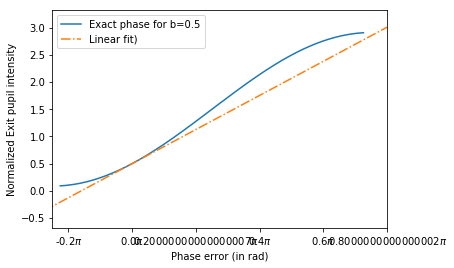

In [40]:
#test function against N'Daiye 2013, figure 5  and recreate the figure:
np.testing.assert_almost_equal(phi(1.5,0.5,1)/np.pi,0.25)
np.testing.assert_almost_equal(phi(0.5,0.5,1)/np.pi,0.0)
I_C=np.arange(-.5,np.pi,.01)
plt.figure(figsize=[6,4])
ax=plt.subplot(111)
plt.plot(phi(I_C,0.5,1)/np.pi,I_C, label='Exact phase for b=0.5')
plt.plot((I_C-0.5)/np.pi,I_C,'-.', label="Linear fit)")# N'Diaye et al Eq. (11

plt.xlabel("Phase error (in rad)")
plt.ylabel("Normalized Exit pupil intensity")
#plt.title("")
plt.legend()
plt.xlim([-0.25,.8])
ax.set_xticklabels([str(tick) +"$\pi$" for tick in ax.get_xticks()])
plt.savefig("figs/I_vs_phase.pdf",bbox_inches="tight")



initing
0.6020348973342008 nm s(1/2) / min(1/2)


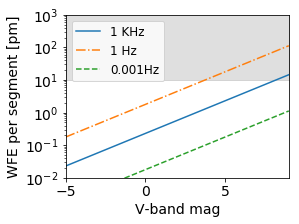

In [41]:
link=lgs.link(tx_divergence=10*u.arcsec,
                tx_laser_power=1*u.watt,
              tx_wavel=wavelength,
              tx_rx_separation=tx_rx_separation)
incident = np.median(link.rx_phot_sec)

mpl.rcParams['font.size'] = 14
#just using same sampling as Jared, is this realistic?
#phot_per_pix = seg_incident/seg_pixels
def wfe_per_photon(photons,wavel):
    return np.sqrt((0.5*u.photon/photons))*wavel/(2*np.pi)
mag=np.arange(-5,10)
wfe_mag_KHz=(wfe_per_photon(efficiency*lgs.zero_mag_Vband*seg_area/sample_freq*10**(-mag/2.5),link.tx_wavel)).to(u.pm)
wfe_mag_0_01hz=(wfe_per_photon(efficiency*lgs.zero_mag_Vband*seg_area/(.01*u.hertz)*10**(-mag/2.5),link.tx_wavel)).to(u.pm)
wfe_mag_sec=(wfe_per_photon(efficiency*lgs.zero_mag_Vband*seg_area/(1/u.second)*10**(-mag/2.5),link.tx_wavel)).to(u.pm)
wfe_mag_0_0001hz=(wfe_per_photon(efficiency*lgs.zero_mag_Vband*seg_area/(.0001*u.hertz)*10**(-mag/2.5),link.tx_wavel)).to(u.pm)



plt.figure(figsize=[4,3])
plt.plot(mag,wfe_mag_KHz,label='1 KHz')

plt.plot(mag,wfe_mag_sec,'-.',label='1 Hz')

#plt.plot(mag,wfe_mag_0_01hz,"--",label='0.01Hz')
plt.plot(mag,wfe_mag_0_0001hz,"--",label='0.001Hz')


plt.fill_between(mag,np.ones(mag.size)*10,np.ones(mag.size)*2000,alpha=0.25,color="gray")
#(10,mag[0],10,mag[-1])


plt.legend(fontsize=12)
plt.ylabel("WFE per segment ["+str(wfe_mag_KHz.unit)+"]")
#plt.ylabel(mag.unit)
#plt.ylim([10,1000])
plt.yscale("log")
print(wfe_sigma_pix)
plt.xlim([mag[0],mag[-1]])
plt.ylim([1e-2,1e3])


plt.xlabel("V-band mag")
plt.savefig("figs/WFE_vs_Vmag.pdf",bbox_inches="tight")

## Earth flux ratio calculation

In [42]:
p=0.2/np.pi#Robinson 2014
rp=1*u.R_earth
a=1*u.astronomical_unit
C_earth=p*(rp/a)**2
C_earth.decompose()


<Quantity 1.15720938e-10>

In [43]:
exoarch_mission = "http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=missionstars&format=votable&select=*"

exoarch_missionraw = astropy.utils.data.download_file(exoarch_mission, 
                                                        cache=False,
                                                        show_progress=True,
                                                        timeout=10)
exoarch_mission = votab.parse(exoarch_missionraw,datatype_mapping={"char": "unicodeChar"}).get_first_table().to_table()

/Users/edouglas/anaconda/envs/astroconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


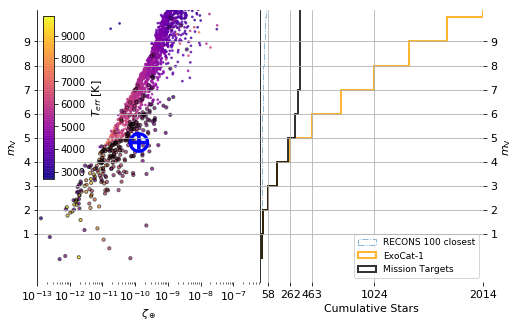

In [44]:
sel=exoarch_mission["st_eeidmas"] 

plt.rcParams["font.size"]=11

Vrecon=recons2012[ 'V'][np.isfinite(recons2012[ 'V'])]
V_exocat=exocat_stars["st_vmag"][np.isfinite(exocat_stars["st_vmag"])]
V_mission=mission_stars["st_vmag"][np.isfinite(mission_stars["st_vmag"])]

#grid=plt.jointplot(exoarch_mission["st_vmag"][sel],exoarch_mission["st_eeidmas"][sel],alpha=.3)#,linewidth=3)
#ax=grid.ax_joint
a=exocat_stars["st_eeidmas"]*exocat_stars["st_dist"]/(206265*1000)*(1.0*u.parsec).to(u.astronomical_unit)
C=p*(rp.to(u.astronomical_unit).value/a)**2
a_mision=exoarch_mission["st_eeidmas"]*exoarch_mission["st_dist"]/(206265*1000)*(1.0*u.parsec).to(u.astronomical_unit)
C_mission=p*(rp.to(u.astronomical_unit).value/a_mision)**2

plt.figure(figsize=[8,5])
ax=plt.subplot(121)

sel=exocat_stars["st_teff"]<10000
sel_exomission=exoarch_mission["st_teff"]<10000


scat=ax.scatter(C[sel],exocat_stars["st_vmag"][:][sel],c=np.array(exocat_stars["st_teff"])[sel],
                cmap=plt.cm.plasma,
                alpha=0.7,
                s=3,
          label=" Stars' Earth-Equivalent Insolation")#,linewidth=3)
          #,linewidth=3)
scat_mission=ax.scatter(C_mission[sel_exomission],exoarch_mission["st_vmag"][:][sel_exomission],
                     #   c=np.array(exoarch_mission["st_teff"])[sel_exomission],
                cmap=plt.cm.plasma,
                alpha=0.6,
                s=10,
                marker="o",
                        facecolors='none', 
                         edgecolors='black',
          label=" Stars' Earth-Equivalent Insolation")#,linewidth=3)
          #,linewidth=3)
ax.set_xlabel(r"$\zeta_\oplus$")
ax.set_xscale("log")
ax.set_xlim(1e-13,C[sel].max())
ax.set_yticks([1,2, 3,4, 5,6,7,8,9])



ax.set_ylabel("V-Mag")
ains = inset_axes(plt.gca(), width='5%', height='60%', loc=2)
ax.set_ylim([-1,10.3])
ax.set_ylabel(r"$m_{\rmV}$")
cb=plt.colorbar(scat,orientation="vertical",cax=ains,label=r"$T_{eff}$ [K]")
cb.ax.tick_params(labelsize=10)
#cb.set_ticklabels(np.round(10**(cb.get_ticks())))

ax.scatter(C_earth.decompose(),4.83,s=500,color='blue',marker='$\oplus$')
#plt.scatter?

ax1=plt.subplot(122)
reconshist=plt.hist(Vrecon,alpha=0.5,cumulative=True,histtype='step',
         #bins=np.arange(1,10,1),
                  bins=mags,align='mid',
                    orientation="horizontal",
    linestyle="-.",
         label="RECONS 100 closest")#recons2012.keys()
#'''
exocathist=plt.hist(V_exocat,alpha=0.8,cumulative=True,#markersize=5,
         color='orange',
                    histtype='step',
                    linewidth=2,
                    orientation="horizontal",
                    label="ExoCat-1",
                  bins=mags,align='mid',)
exocathist_mission=plt.hist(V_mission,alpha=0.8,cumulative=True,#markersize=5,
         color='black',
                    histtype='step',
                    linewidth=2,
                    orientation="horizontal",
                    label="Mission Targets",
                  bins=mags,align='mid',)



xy = (0.2, 0.2)
from matplotlib.patches import ConnectionPatch


ax1.set_xlim([0,ax1.get_yticks()[-1]])
ax1.set_ylim(ax.get_ylim())
ax1.set_yticks([])
ax1.set_xticks([0,500, 1000, 1500])



ax1.set_xlabel("Cumulative Stars")
ax1_twin=ax1.twinx()


ax1_twin.set_frame_on(False)
#ax1_twin_top.set_frame_on(False)


ax1_twin.set_ylim(ax.get_ylim())
#ax1_twin.set_yticks(ax.et_yticks())
plt.draw()
ax1_twin.set_yticks(ax.get_yticks())
#ax1_twin_top.set_xticks()

ax1_twin.set_yticklabels(ax.get_yticklabels(which='both'))


ax1.set_xlim([-10,exocathist[0][np.where(exocathist[1]==10)]])
ax1.set_yticklabels("")
ax1_twin.set_ylabel(r"$m_{\rmV}$")



#ax1_twin_top=ax1.twiny()
ax1.set_xticks([exocathist[0][np.where(exocathist[1]==2)], #1000,
                exocathist[0][np.where(exocathist[1]==4)], #1000,

                exocathist[0][np.where(exocathist[1]==5)], #1000,

                exocathist[0][np.where(exocathist[1]==7)], #1000,
                exocathist[0][np.where(exocathist[1]==10)]])
#ax1_twin_top.grid()
ax1_twin.grid()
ax1.grid()
#ax1.grid?
ax.grid(axis="y")

plt.subplots_adjust(wspace=0, hspace=0)

#plt.tight_layout()

turn_off_axes=["top","bottom","right",]
for spine in turn_off_axes:
    ax1.spines[spine].set_visible(False)
    ax.spines[spine].set_visible(False)
    ax1_twin.spines[spine].set_visible(False)
    #ax1_twin_top.spines[spine].set_visible(False)


ax1.legend(loc="lower right",fontsize=9)
plt.savefig("figs/vmag_vs_V_cumulative.pdf",bbox_inches="tight")

In [45]:
#exoarch_mission["st_"][:][sel_exomission]
near=exocat_stars["st_dist"]<3
exocat_stars[:][near]

hip_name,hd_name,gj_name,tm_name,st_exocatflag,st_coronagflag,st_starshadeflag,st_wfirstflag,st_rvflag,st_lbtiflag,st_probeflag,st_k2flag,st_k2campaign,st_ppnum,wds_designation,wds_sep,wds_deltamag,ra,raerr,rastr,dec,decerr,decstr,st_glon,st_glonerr,st_glat,st_glaterr,st_fracplxunc,st_dist,st_disterr1,st_disterr2,st_pmra,st_pmraerr,st_pmdec,st_pmdecerr,st_vmag,st_vmagerr,st_vmagsrc,st_kmagsrc,st_bmv,st_bmverr,st_bmvsrc,st_vmk,st_vmkerr,st_vmksrc,st_spttype,st_lumclass,st_spttag,st_mbol,st_mbolerr,st_mbolsrc,st_mbolflag,st_lbol,st_lbolerr,st_lbolsrc,st_teff,st_tefferr,st_teffsrc,st_logg,st_loggerr,st_loggsrc,st_metfe,st_metfeerr,st_metfesrc,st_metratio,st_rad,st_raderr,st_radsrc,st_mass,st_masserr,st_masssrc,st_age,st_ageerr,st_agesrc,st_actclass,st_eeidau,st_eeidauerr,st_eeidmas,st_eeidmaserr,st_fpbearth,st_fpbeartherr,st_vmagearth,st_vmageartherr,st_nts,st_nplc,st_nglc,st_nrvc,st_naxa,st_nimg,st_nspec,st_j2m,st_j2merr,st_j2mlim,st_h2m,st_h2merr,st_h2mlim,st_ks2m,st_ks2merr,st_ks2mlim,st_wise1,st_wise1err,st_wise1lim,st_wise2,st_wise2err,st_wise2lim,st_wise3,st_wise3err,st_wise3lim,st_wise4,st_wise4err,st_wise4lim,star_name,id
,,,,,,,,,,,,,,,arcs,mags,deg,degrees,,deg,degrees,,degrees,degrees,degrees,degrees,,pc,pc,pc,mas / yr,mas / yr,mas / yr,mas / yr,mags,mags,,,mags,mags,,mags,mags,,,,,mags,mags,,,Lsun,Lsun,,K,K,,cm/s**2,cm/s**2,,dex,dex,,,Rsun,Rsun,,Msun,Msun,,Gyr,Gyr,,,AU,AU,mas,mas,,,mag,mag,,,,,,,,mags,mags,,mags,mags,,mags,mags,,mags,mags,,mags,mags,,mags,mags,,mags,mags,,,
object,object,object,object,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,object,float64,float64,float64,float64,object,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,object,float64,float64,object,object,object,object,float64,float64,object,int32,float64,float64,object,float64,float64,object,float64,float64,object,float64,float64,object,object,float64,float64,object,float64,float64,object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,float64,float64,int32,object,object
HIP 32349,HD 48915,GJ 244 A,2MASS J06450887-1642566 A,1,1,1,0,0,0,1,0,--,0,06451-1643,--,--,101.289,--,06h45m09.25s,-16.713,--,-16d42m47.3s,227.228206,--,-8.887735,--,0.0,2.63,--,--,-546.0,--,-1223.1,--,-1.44,0.0,G,Koornneef,0.01,0.01,G,-0.05,0.05,,A1.0V,MAINSEQ,A,1.46,0.01,,0,30.48,0.05,V-K,9580.0,--,Gray,4.2,--,Gray,--,--,,,2.0,--,Turnbull,2.4,--,Turnbull,--,--,,,5.52,--,2098.14,--,0.0,--,27.11,--,1,0,1,0,0,2,0,-1.391,0.109,0,-1.391,0.184,0,-1.39,0.214,0,--,--,--,--,--,--,--,--,--,--,--,--,HIP 32349,663
HIP 54035,HD 95735,GJ 411,2MASS J11032027+3558203,1,0,0,0,0,0,0,0,--,0,,--,--,165.836,--,11h03m20.61s,35.981,--,+35d58m53.3s,185.090646,--,65.430293,--,0.0,2.54,--,--,-580.2,--,-4767.1,--,7.49,0.01,G,,1.5,0.01,G,--,--,,M2.0V,MAINSEQ,M,10.46,0.02,,0,0.02,0.1,B-V,3611.0,--,B-V,--,--,,--,--,,,0.4,--,Turnbull,0.39,--,Turnbull,--,--,,,0.16,--,61.72,--,0.0,--,28.31,--,1,0,1,0,0,3,11,4.32,0.282,0,3.722,0.224,0,3.501,0.352,0,--,--,--,--,--,--,--,--,--,--,--,--,HIP 54035,1044
HIP 70890,,GJ 551,2MASS J14294291-6240465,1,0,0,0,0,0,0,0,--,0,,--,--,217.449,--,14h29m47.75s,-62.681,--,-62d40m52.9s,313.947714,--,-1.932215,--,0.0,1.3,--,--,-3775.6,--,768.2,--,11.01,0.01,G,,1.81,0.02,G,--,--,,M5.0V,MAINSEQ,M,15.44,0.02,,0,0.0,0.1,B-V,--,--,,--,--,,--,--,,,--,--,,0.16,--,Turnbull,--,--,,,0.03,--,22.5,--,0.0,--,28.18,--,1,0,1,0,0,2,0,5.357,0.023,0,4.835,0.057,0,4.384,0.033,0,--,--,--,--,--,--,--,--,--,--,--,--,HIP 70890,1393
HIP 71681,HD 128621,GJ 559 B,2MASS J14393592-6050069 B,1,1,1,1,0,0,1,0,--,1,14396-6050,5.0,1.1,219.914,--,14h39m39.39s,-60.839,--,-60d50m22.1s,315.737332,--,-0.686979,--,0.0,1.34,--,--,-3600.3,--,952.1,--,1.35,0.01,G,Koornneef,

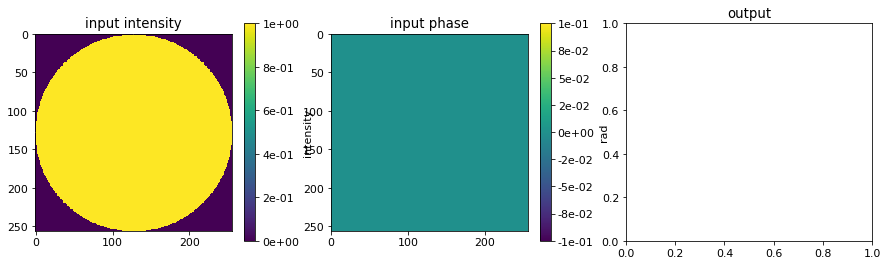

In [46]:
#jwst_pupil_RevW_npix1024.fits
import poppy
import astropy.io.fits as fits
from zwfs import *


wl=532*u.nm
beam_r=9.8/2*u.m#16.8/2*u.m
f=2
#1.06lmabda/D|
#mask_radius=0.01e-4*u.m
oversample=8
wl=980*u.nm
npix=256
w=beam_r*2
mask_radius=0.5*1.06*wl/(beam_r*2)*beam_r*f #N'Diaye et al 2013 optimal radius


wf = poppy.FresnelWavefront(beam_radius=beam_r,oversample=oversample,npix=npix,wavelength=wl)
#wf*=poppy.ZernikeWFE(radius=beam_r.to(u.m).value,coefficients=[0,0,0,0,0,1e-7])
#for now, do everything on a circular basis to make the optimum phase mask size is right
wf *= poppy.CircularAperture(radius=beam_r)
#wf *= poppy.GaussianAperture(w=w,)


plt.figure(figsize=[15,4])
ax1=plt.subplot(131)
input_intensity=get_intensity(wf.copy())
plt.imshow(input_intensity,interpolation='nearest')
plt.title("input intensity")
plt.colorbar( format='%.0e',label="intensity")
input_wf=wf.copy()

ax2=plt.subplot(132)
phase=poppy.utils.removePadding(wf.copy().phase,oversample=wf.oversample)
plt.imshow(phase,interpolation='nearest')
plt.title("input phase")
plt.colorbar( format='%.0e',label="rad")
wf *= poppy.QuadraticLens(f_lens=np.float_((beam_r*f).value))
wf.propagate_fresnel(beam_r*f)
#tune the shift and the size of the mask here:
mask_radius=0.5*1.06*wf.wavelength/(beam_r*2)*beam_r*f #N'Diaye et al 2013 optimal radius
wf *= CircularPhaseShift(radius=mask_radius,shift=1.25)
#plt.figure()
#wf.display(what="both")


wf.propagate_fresnel(beam_r*2)

ql2=poppy.QuadraticLens(f_lens=(beam_r*f).value+1e-32)
wf *= ql2
ax3=plt.subplot(133)
plt.title("output")


no_abb_wf=wf.copy()
no_abberation_phi=phi(get_intensity(no_abb_wf))#,np.sqrt(get_intensity(no_abb_wf)))




INFO:poppy:OPD from supplied fits.HDUList object: Loaded OPD from supplied fits.HDUList object
INFO:poppy:No info supplied on amplitude transmission; assuming uniform throughput = 1
/Users/edouglas/anaconda/envs/astroconda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


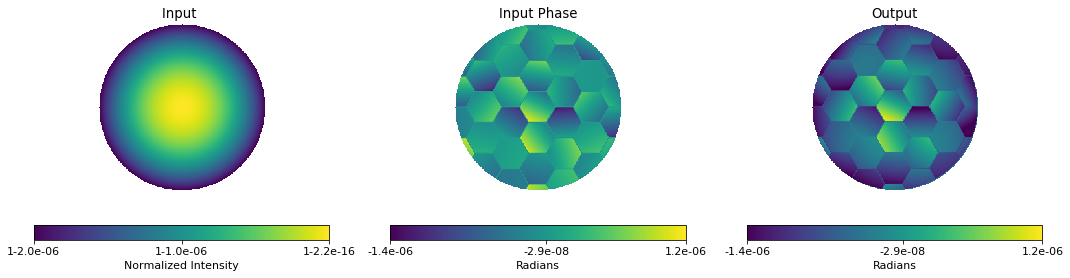

In [47]:
wfe_file="data/segment_jitter/PSD_x1.fits"
lgsa=fits.open(wfe_file)
lgsa[0].data=lgsa[0].data*wl.to(u.nm).value/(2*np.pi)
wf = poppy.FresnelWavefront(beam_radius=beam_r,
                            oversample=oversample,
                            npix=npix,
                            wavelength=wl)
#wf*=poppy.ZernikeWFE(radius=beam_r.to(u.m).value,coefficients=[0,0,0,0,0,1e-7])
lgsa[0].header["PUPLSCAL"]=beam_r.to(u.m).value/160
ga=poppy.GaussianAperture(w=w*500)
wf *= ga#,shift_x=shift_x)
wf *= poppy.FITSOpticalElement(opd=lgsa,opdunits="nm")
wf *= poppy.CircularAperture(radius=beam_r)
#input_wf_abb_tilted=wf.copy()

phase=np.ma.masked_array(poppy.utils.removePadding(wf.copy().phase,
                                                   oversample=wf.oversample),
                        )
phase.mask= phase ==0


plt.figure(figsize=[15,4])
ax1=plt.subplot(131)
inp_inten=np.ma.masked_array(get_intensity(wf),mask=phase.mask)-1
plt.imshow(inp_inten,interpolation='nearest')

plt.title("Input ")
cm=plt.colorbar( format='1%2.1e',orientation="horizontal",label="Normalized Intensity")
cm.set_ticks([inp_inten.min(), inp_inten.mean(),inp_inten.max()])




ax2=plt.subplot(132)


plt.title("Input Phase")# [rad]")
plt.imshow(phase,interpolation="nearest")#,vmax=1e-6,vmin=-1e-6)
cm=plt.colorbar( format='%2.1e',orientation="horizontal",label="Radians")

cm.set_ticks([np.nanmin(phase), phase.mean(),phase.max()])
#,label="rad")





wf *= poppy.QuadraticLens(f_lens=beam_r*f)
wf.propagate_fresnel(beam_r*f)
#tune the shift and the size of the mask here:
wf *= CircularPhaseShift(radius=mask_radius,shift=0.25)

wf.propagate_fresnel(beam_r*2)
wf *= poppy.QuadraticLens(f_lens=beam_r*f)

ax3=plt.subplot(133)
plt.title("Output")# [rad]")
out=np.ma.masked_array(np.fliplr(np.flipud(phi(get_intensity(wf))-no_abberation_phi+0.5),),mask=phase.mask)-.5

plt.imshow(out,interpolation='nearest',vmin=np.nanmin(phase), vmax=phase.max())
                      # vmax=1e-6,vmin=-1e-6)


cm=plt.colorbar( format='%2.1e',orientation="horizontal",label="Radians")
cm.set_ticks([np.nanmin(phase), phase.mean(),phase.max()])





'''ax3=plt.subplot(133)
plt.title("Corrected Output")

zout=np.ma.masked_array(-np.fliplr(np.flipud(get_intensity(wf))),
                        mask=phase ==0,vmax=3e-6,vmin=-3e-6)



plt.imshow(zout,interpolation='nearest')
plt.colorbar( format='%.0e',label="rad")

'''
for ax in [ax1,ax2,ax3]:
    ax.set_yticklabels("")
    ax.set_xticklabels("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

    #make boarder thickness 0?

plt.tight_layout()
plt.savefig("figs/ZWFS_gaussian_illum_segmented.pdf",bbox_inches="tight")



# Misc. Calculations

In [48]:
z=47e4*u.km
f=1
w0=100*u.mm#4*wavelength/np.pi*5
wl=wavelength
dR=z*(1+(16*wl*f**2/np.pi/z)**2)*(16*wl/np.pi/z)**2*f**3
dR.decompose()

<Quantity 5.30022753e-20 m>

In [49]:
R_T=D_t/2
(R_T**2/(2*z)).decompose()

<Quantity 2.25106383e-08 m>

In [50]:
z*(1+(np.pi*w0**2/wl/z)**2)
e=50*u.m

In [51]:
(z*(1+(np.pi*w0**2/wl/z)**2)-(z*(1+(np.pi*(w0+1*u.um)**2/wl/z)**2))).decompose()

<Quantity -8.74279067e-05 m>

In [52]:
(D_t/2/((3.862*u.arcsecond).to(u.radian).value*43184.0*u.km)).decompose()

<Quantity 0.00568916>

PV curvature:

In [53]:
w_incident=(3.862*u.arcsecond).to(u.radian).value*43184.0*u.km
(z-np.sqrt(z**2-(D_t/2)**2))/(z-np.sqrt(z**2-w_incident**2))

<Quantity 8.36960161e-05>

In [54]:
IWA=(400*u.nm*3.75/(15*u.m)*u.radian).to(u.milliarcsecond) #pueyo 2017
IWA

<Quantity 20.62648062 marcsec>

In [55]:
# divergence vs pointing jitter, Eq.10
dI=10*u.pm*(2*np.pi/(wavelength)) #phase error ~ intensity error
x0=15*u.milliarcsecond #angular LGS pointing error
w=np.sqrt((2*x0**2/dI)).decompose()#angular beam width
(w/x0).decompose()

<Quantity 176.61927654>